In [1]:
import numpy
import numpy as np
import pandas as pd
import time
import datetime
import os,sys,glob
import json
import copy
import pickle


import warnings
warnings.filterwarnings('ignore')


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd


import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import matplotlib.colors as mcolors
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 3


import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)

In [2]:
def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)"] #, "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

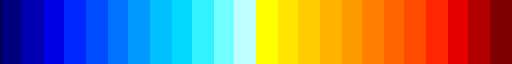

In [3]:
cmnew

In [51]:
def world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-1, inp_vmax=1):
    renamer = {}
    for i in df_d:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_d = df_d.rename(columns=renamer)

    renamer = {}
    for i in df_u:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_u = df_u.rename(columns=renamer)

    for i in df_u:
        if i != 'expver':
            df_u[i] = df_u[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    for i in df_d:
        if i != 'expver':
            df_d[i] = df_d[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    df_d = df_d[~np.isnan(df_d.fg_depar)]
    df_u = df_u[~np.isnan(df_u.fg_depar)]

    for p in [plev]:
        df_d_p = df_d[df_d.vertco_reference_1==p]
        df_u_p = df_u[df_u.vertco_reference_1==p]
    limit = [1,99]
    out = {'stat':[],'me':[],'lat':[],'lon':[], 'number':[]}
    for stat in df_u_p.statid.drop_duplicates():
        all_diffs = []
        df_u_stat = df_u_p[df_u_p.statid==stat]
        df_d_stat = df_d_p[df_d_p.statid==stat]
        # display(df_u_stat)
        # display(df_d_stat)
        for obs in range(len(df_u_stat)):
            df_i = df_u_stat.iloc[obs]
            df_comp = df_d_stat[np.logical_and(np.logical_and(df_d_stat.antime == df_i.antime, df_d_stat.andate == df_i.andate),df_d_stat.obsvalue == df_i.obsvalue)]
            if len(df_comp) > 1:
                # print()
                sel = np.argmin(np.abs(df_comp.time - df_i.time))
                # print(df_i.time, df_comp.iloc[sel].time)
                all_diffs.append(df_i.fg_depar - df_comp.iloc[sel].fg_depar)
            elif len(df_comp) < 1:
                continue
            else:
                all_diffs.append(df_i.fg_depar - df_comp.fg_depar.values[0])
        if len(all_diffs) > 2:
            out['stat'].append(stat)
            data = np.array(all_diffs)
            outlier_drop = np.nanpercentile(data, limit)
            data[data < outlier_drop[0]] = np.nan
            data[data > outlier_drop[1]] = np.nan
            out['me'].append(np.nanmean(data))
            out['lat'].append(df_u_stat.lat.iloc[0])
            out['lon'].append(df_u_stat.lon.iloc[0])
            out['number'].append(len(all_diffs))


    out_df = pd.DataFrame.from_dict(out)
    plt_world_map(out_df, str(plev/100)+" hPa", year, var, inp_vmin, inp_vmax)
    plt_world_map(out_df, "number of observations", year, var, 0, 100, number=True)
    
def plt_world_map(lla, pl ,year, var, inp_vmin, inp_vmax, number = False):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    if number:
        plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                    c=lla["number"], 
                    cmap= cmnew,
                    vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
                  )
        ax.set_title("ME difference "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
        ax.grid()
        plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                    c=lla["me"], 
                    cmap= cmnew,
                    vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
                  )
        ax.set_title("ME difference "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
        ax.grid()
        plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
        plt.tight_layout()
        plt.show()
        fig.savefig("ME_difference_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
        plt.close()

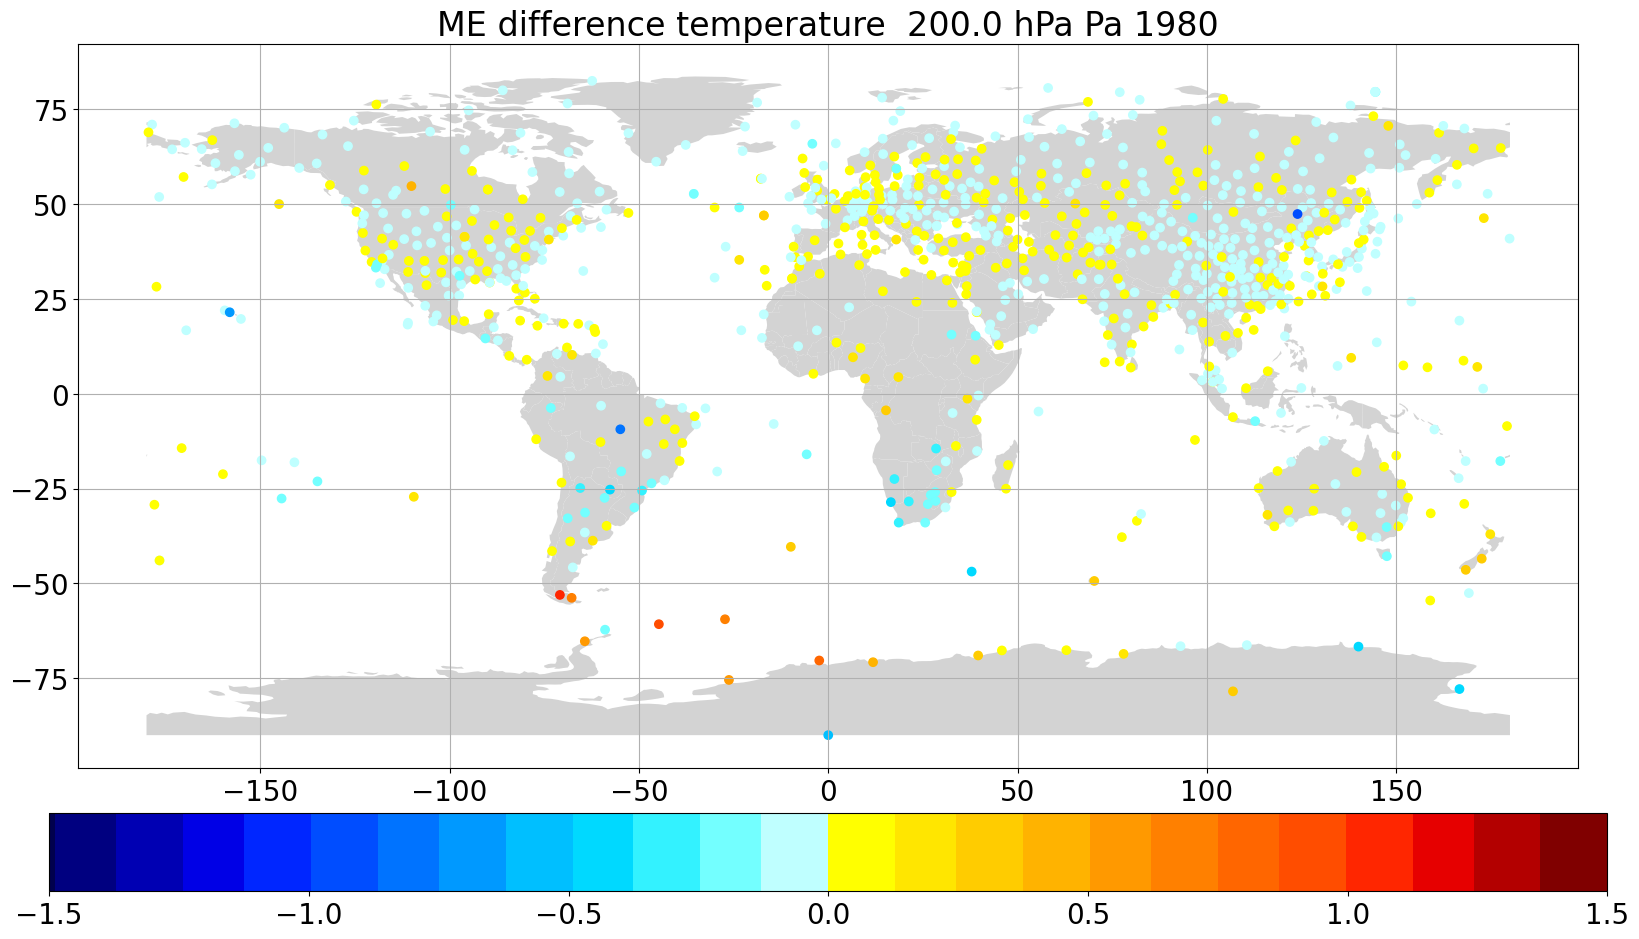

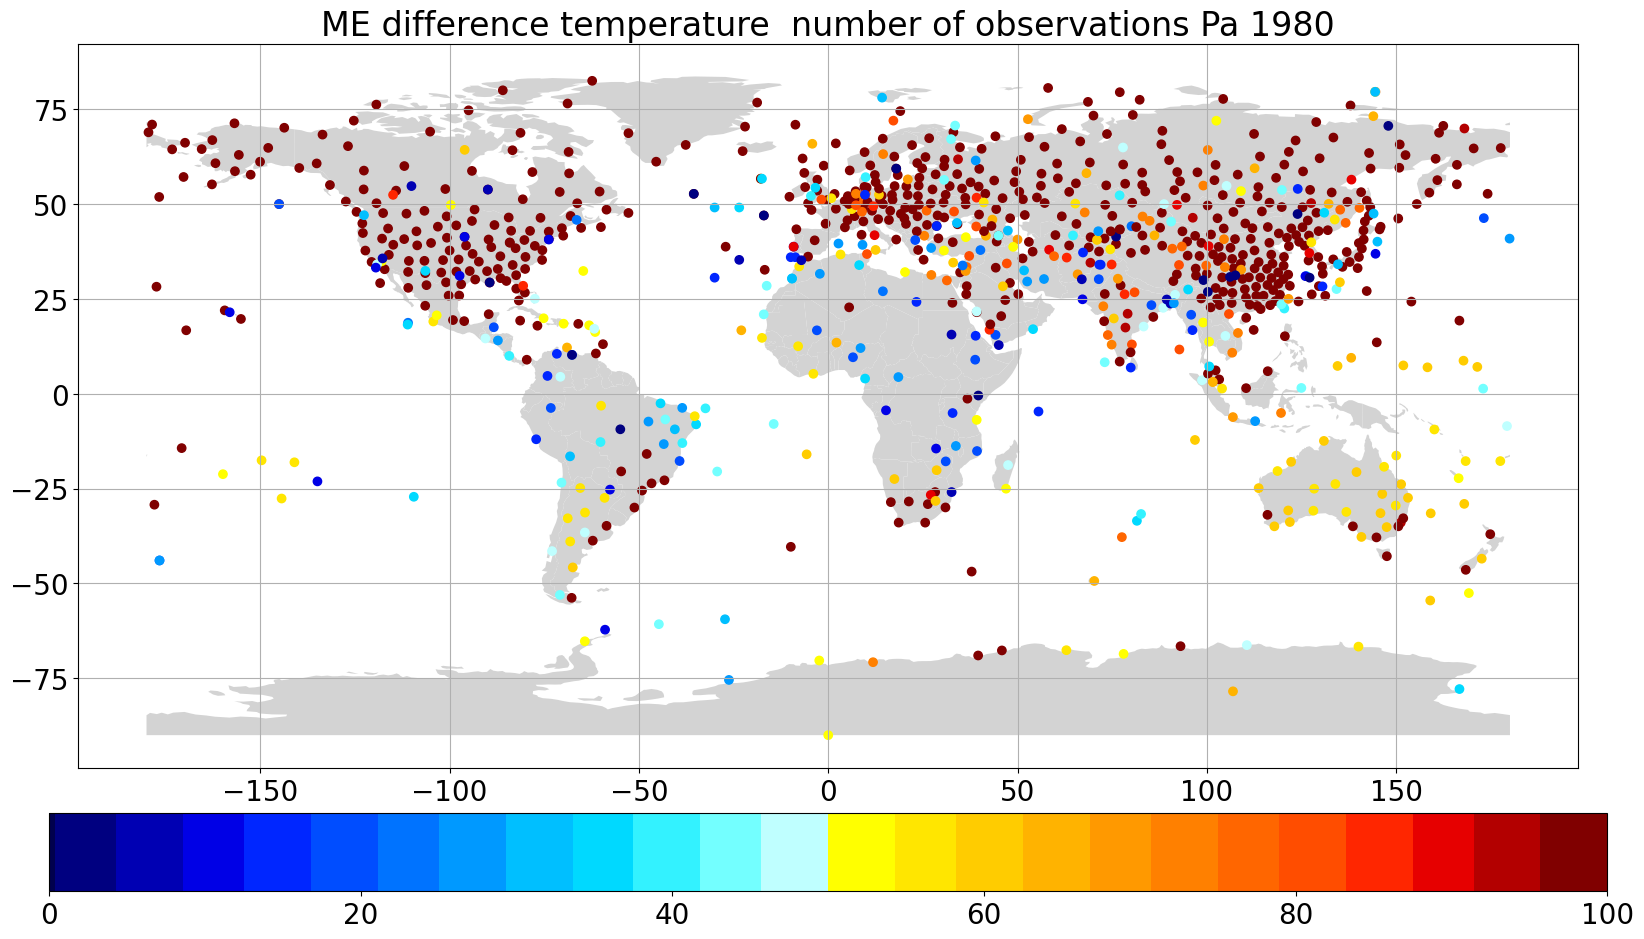

In [52]:
var = 'temperature'
year = '1980'
plev = 20000

df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675.csv', delimiter='\t')

world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)


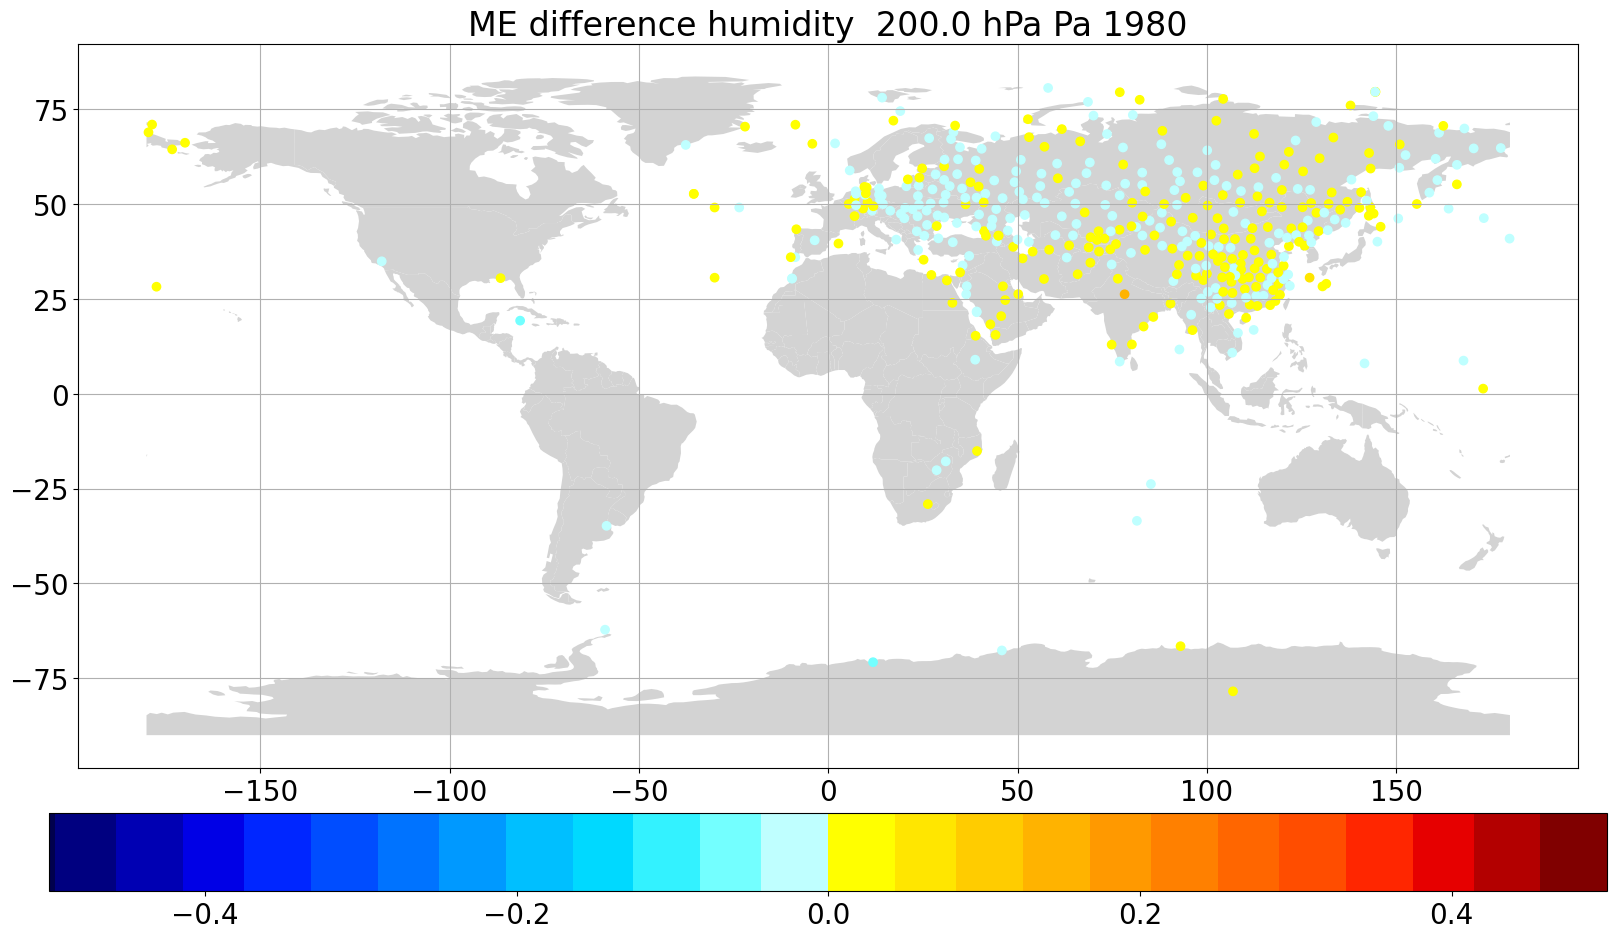

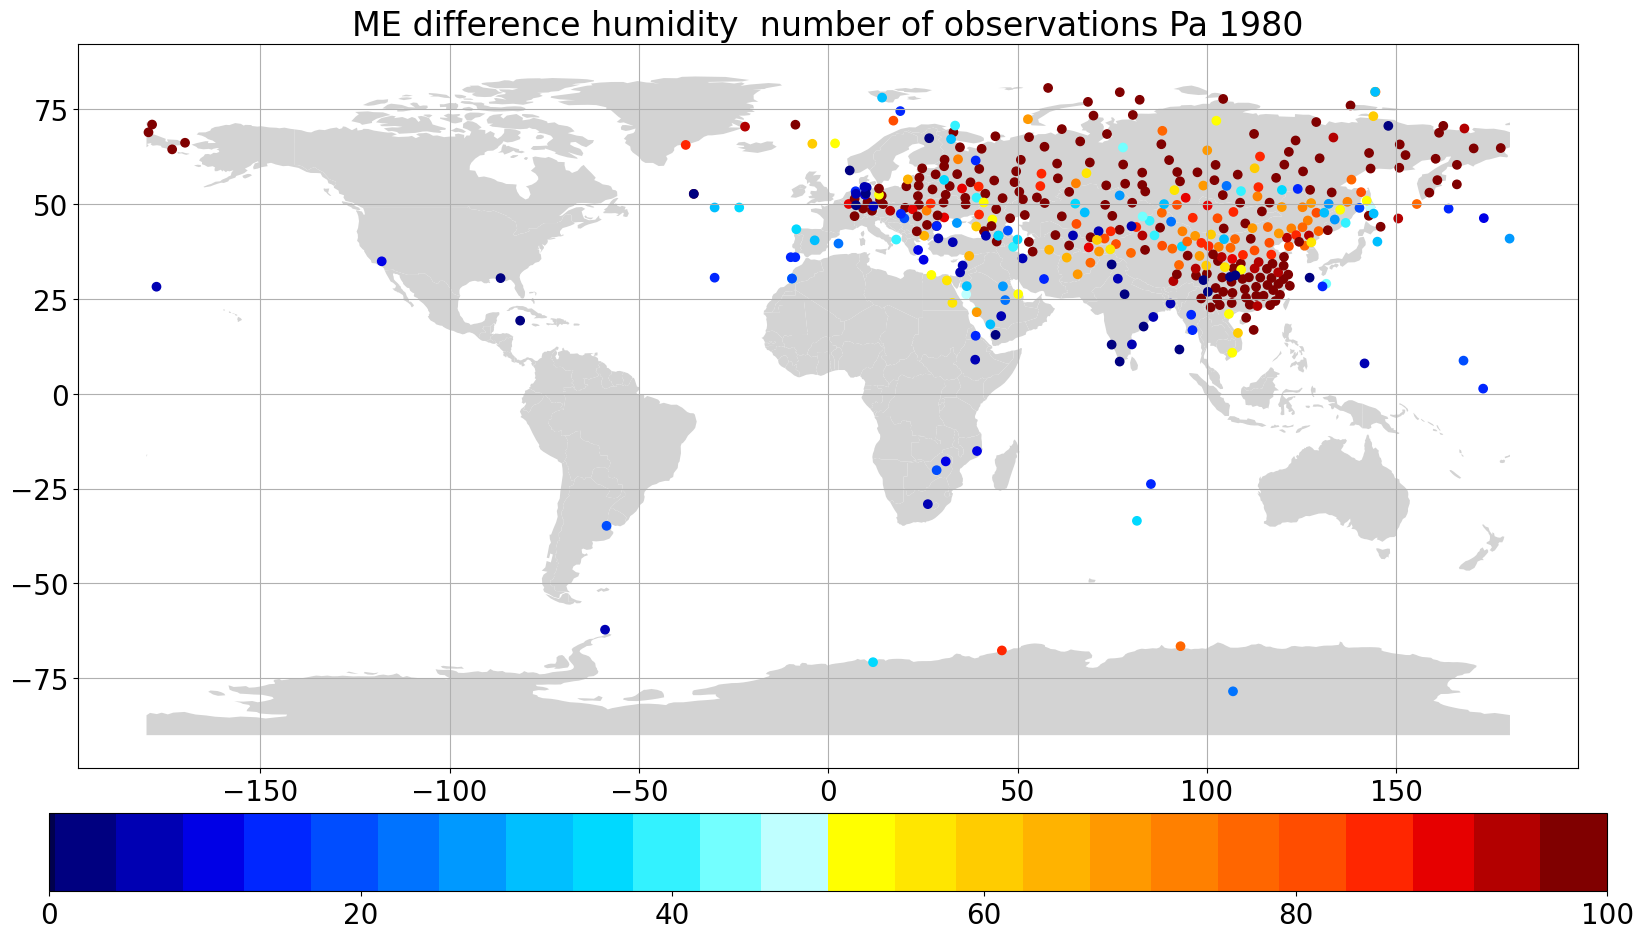

In [53]:
var = 'humidity'
year = '1980'
plev = 20000

df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671_rh.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675_rh.csv', delimiter='\t')

world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-0.5, inp_vmax=0.5)


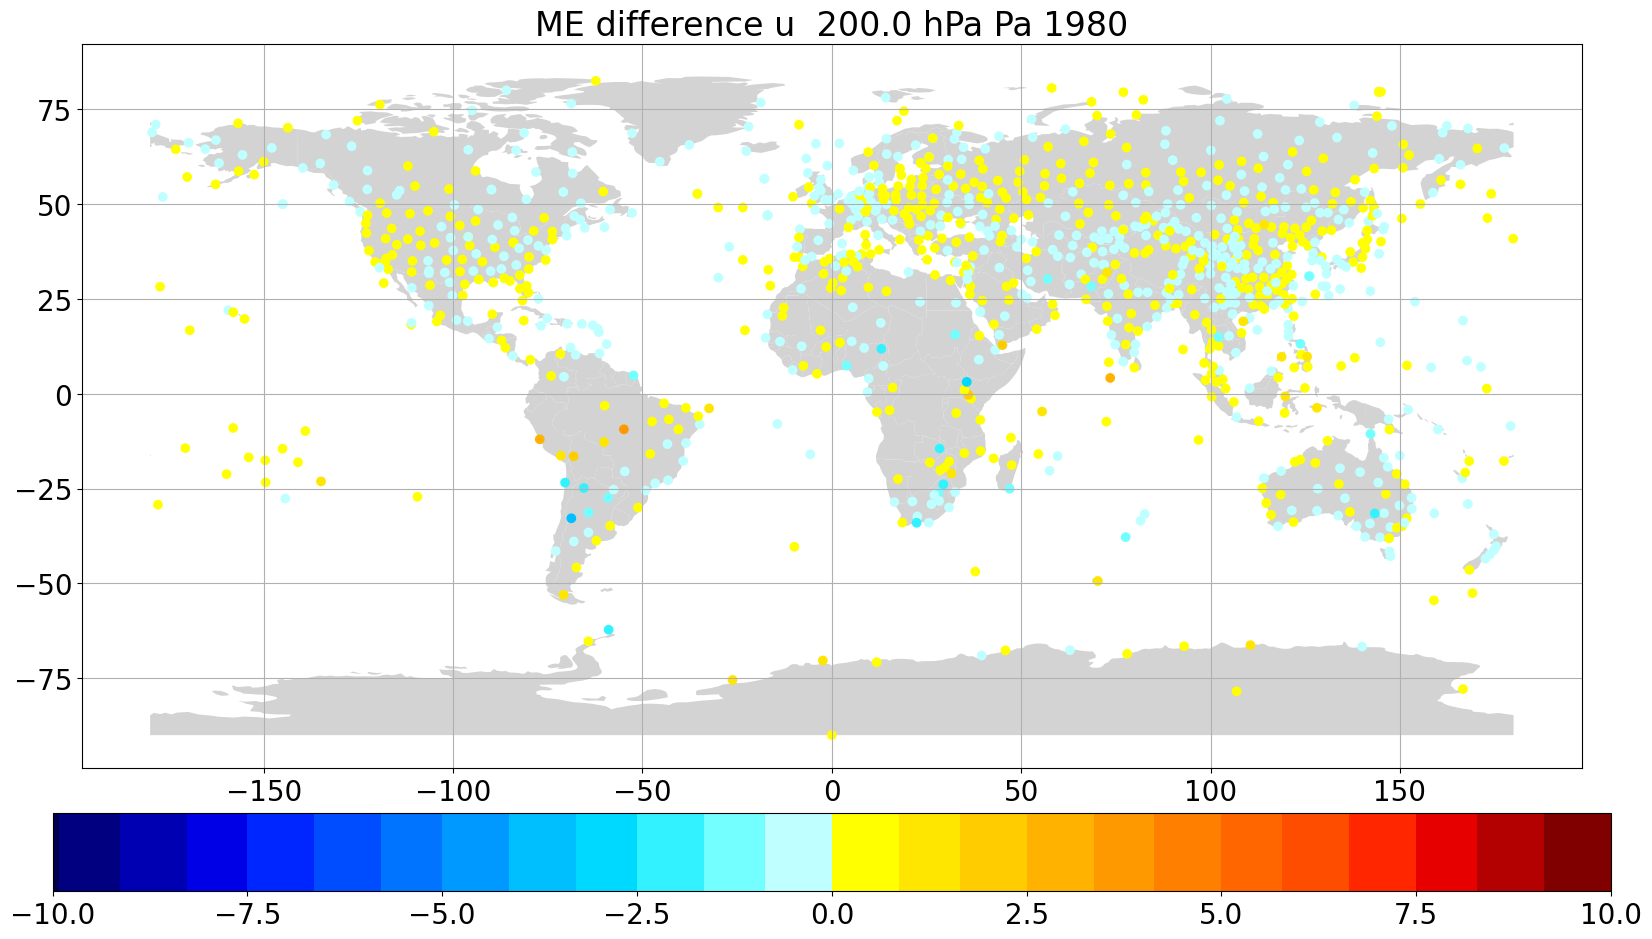

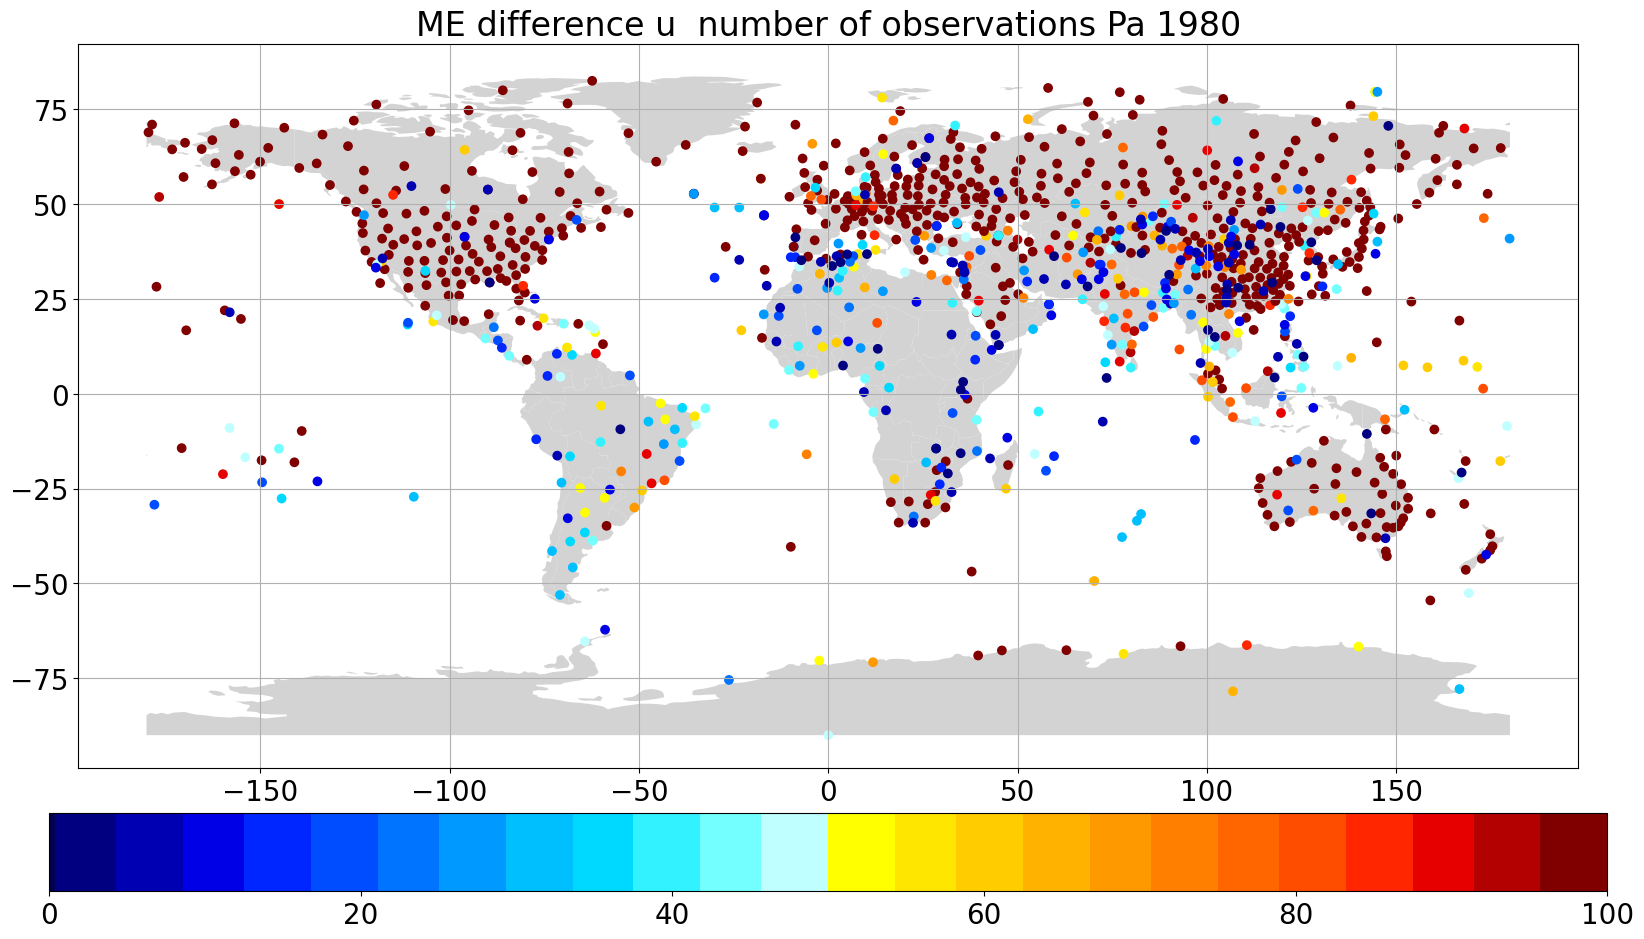

In [54]:
var = 'u'
year = '1980'
plev = 20000

df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671_u.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675_u.csv', delimiter='\t')

world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-10, inp_vmax=10)


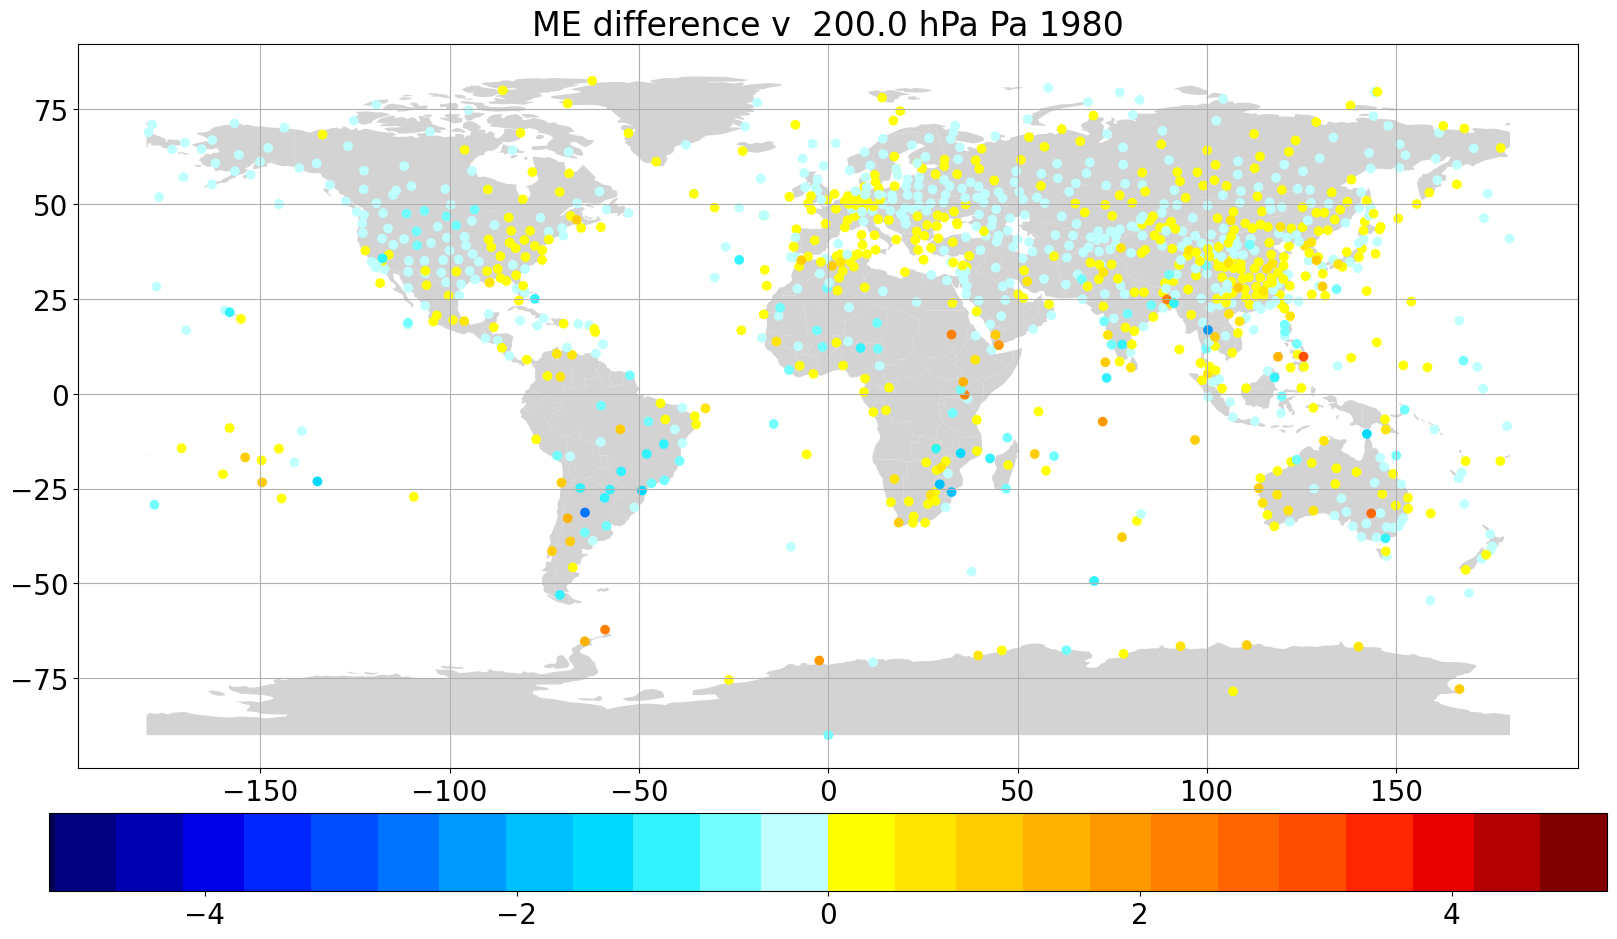

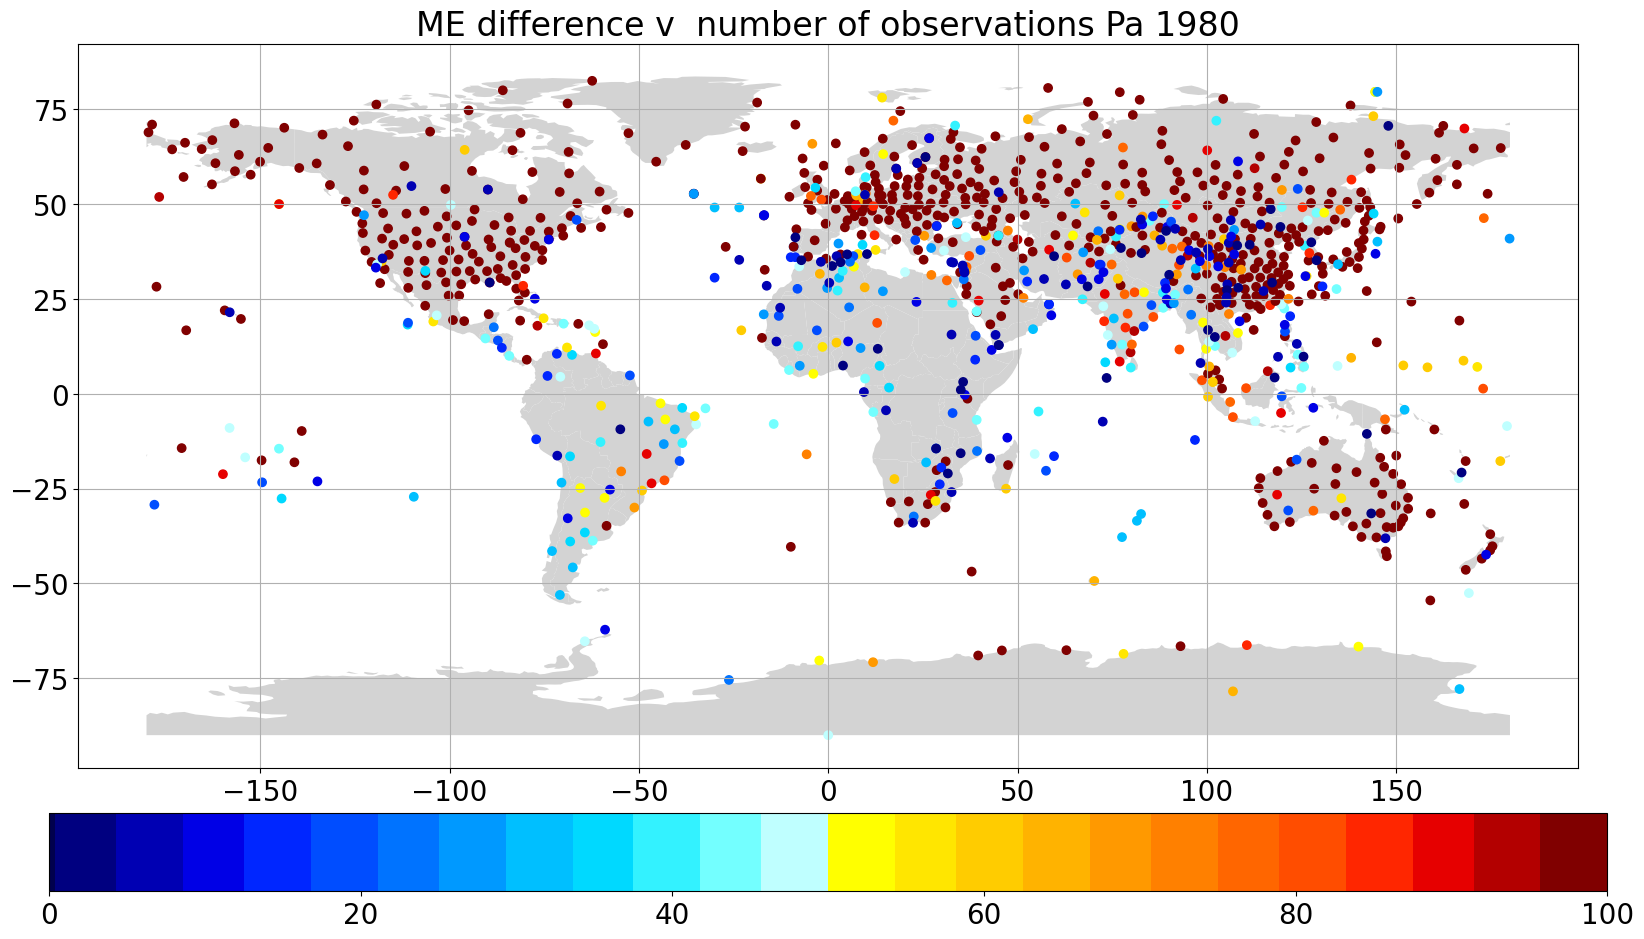

In [55]:
var = 'v'
year = '1980'
plev = 20000

df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671_v.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675_v.csv', delimiter='\t')

world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-5, inp_vmax=5)
